In [1]:
from models._config import C
from dataset.RadarDataset import RadarSignalDataset  

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.utils.rnn as rnn_utils
from matplotlib import pyplot as plt
    
# Temporal Attention Layer (Zero-padding에 대한 가중치 조정 포함)
class SelfAttention(nn.Module):
    def __init__(self, hidden_size):
        super(SelfAttention, self).__init__()
        self.hidden_size = hidden_size
        self.attn = nn.Linear(hidden_size * 2, hidden_size)  # 
        self.v = nn.Parameter(torch.rand(hidden_size)) # 
        
    def forward(self, hidden_states, mask=None):
        """
        hidden_states: [batch_size, seq_len, hidden_size * 2]
        mask: [batch_size, seq_len] - zero-padding mask
        """
        attn_weights = torch.tanh(self.attn(hidden_states))  # [batch_size, seq_len, hidden_size]
        attn_weights = attn_weights.matmul(self.v)           # [batch_size, seq_len]
        attn_weights = F.softmax(attn_weights, dim=1)        # [batch_size, seq_len]에서 softmax로 중요도 결정
        
        # 가중치를 반영하여 각 타임 스텝의 hidden state를 곱해줌
        context = torch.sum(hidden_states * attn_weights.unsqueeze(-1), dim=1)  # [batch_size, hidden_size * 2]
        return context, attn_weights

class BiLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(BiLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True, dropout=0.3)
        
        self.attention = SelfAttention(hidden_size)
        
        self.fc = nn.Linear(hidden_size * 2, num_classes)  
        
        self.dropout = nn.Dropout(0.5)

    def forward(self, x, lengths, lstm_outputs=False):
        device = self.device
        x = x.to(device)
        lengths = lengths.to(device)
        print("f", x.device, lengths.device)
        batch_size, seq_len, _ = x.size()

        h0 = torch.zeros(self.num_layers * 2, batch_size, self.hidden_size, device=device)
        c0 = torch.zeros(self.num_layers * 2, batch_size, self.hidden_size, device=device)
        packed_x = rnn_utils.pack_padded_sequence(x, lengths, batch_first=True, enforce_sorted=False)
        
        
        packed_out, (hn, cn) = self.lstm(packed_x, (h0, c0))
        out, _ = rnn_utils.pad_packed_sequence(packed_out, batch_first=True)
        mask = torch.arange(seq_len).expand(batch_size, seq_len).to(device) < lengths.unsqueeze(1).to(device)
        
        context, attn_weights = self.attention(out, mask) 
        
        out_last = self.dropout(context) 
        out_fc = self.fc(out_last) 
                
        if lstm_outputs:
            return out_fc, out, attn_weights
        else:
            return out_fc


    @staticmethod        
    def collate(batch):
        data, labels, snrs, lengths = zip(*batch)
        
        data_pad = rnn_utils.pad_sequence([torch.tensor(seq, dtype=torch.float32) for seq in data], batch_first=True)
        
        labels = torch.tensor([c.label_mapping[label] for label in labels], dtype=torch.long)
        snrs = torch.tensor(snrs, dtype=torch.int64)
        lengths = torch.tensor(lengths, dtype=torch.int64)  # 시퀀스 길이를 함께 전달

        return data_pad, labels, snrs, lengths
    
import torch

class LRP:
    def __init__(self, model, device, epsilon=1e-6):
        self.model = model
        self.epsilon = epsilon
        self.device = device
    
    def relevance(self, x, lengths, target=None):
        x = x.to(self.device)
        lengths = lengths.to(self.device)
        output, h, a = self.model(x, lengths, lstm_outputs=True)
        target = torch.argmax(output, dim=1) if target is None else target
        # Output shape: torch.Size([B, cls])
        # Hidden states shape: torch.Size([B, T, H*2])
        # Attention weights shape: torch.Size([B, T])
        # Context shape: torch.Size([B, H*2])
        
        r = torch.zeros_like(output)
        for i in range(output.size(0)):
            r[i, target[i]] = output[i, target[i]] # Target class에 대한 relevance만 생존
        
        r_c = self.bpp_fc(h, r)
        r_h = self.bpp_att(r_c, h, a)
        r_x = self.bpp_bilstm(r_h, h, x, lengths)
        
        # ground truth
        gt_label = torch.argmax(output, dim=1)
        return r_c, r_h, r_x, a, h, gt_label
    
    def lstm_gates(self, x_t, h_prev, W_ih, W_hh, b_ih, b_hh, cl_prev):
        x_t = x_t.to(self.device)
        h_prev = h_prev.to(self.device)
        cl_prev = cl_prev.to(self.device)
        
        gates = torch.matmul(W_ih, x_t) + torch.matmul(W_hh, h_prev) + b_ih + b_hh
        i_t, f_t, o_t, g_t = torch.chunk(gates, 4, dim=0)
        
        i_t = torch.sigmoid(i_t)
        f_t = torch.sigmoid(f_t)
        o_t = torch.sigmoid(o_t)
        cl_t = f_t * cl_prev + i_t * torch.tanh(g_t)
        
        return (f_t, i_t, o_t, cl_t)
        
    def bpp_bilstm(self, rel_h, h, x, lengths):
        B, T, H = h.size()
        H = H // 2
        D = x.size(-1)
        
        rel_x_fw = torch.zeros(B, T, D)                     # [B, T, D]
        rel_cl_fw_t1 = torch.zeros(B, H)                    # [B, H]
        W_ih = self.model.lstm.weight_ih_l0                             # [4*h, input_size]
        W_hh = self.model.lstm.weight_hh_l0                             # [4*h, hidden_size]
        b_ih = self.model.lstm.bias_ih_l0
        b_hh = self.model.lstm.bias_hh_l0
        
        rel_x_bw = torch.zeros(B, T, 2)
        rel_cl_bw_t1 = torch.zeros(B, H)
        W_ih_bw = self.model.lstm.weight_ih_l0_reverse
        W_hh_bw = self.model.lstm.weight_hh_l0_reverse
        b_ih_bw = self.model.lstm.bias_ih_l0_reverse
        b_hh_bw = self.model.lstm.bias_hh_l0_reverse
        
        # relevance는 cell state와 gate 값들을 통해 전파됨
        # rel_h_t : [B, T, sigma]
        # rel_x_fw[i, t] : [d] / rel_cl_fw_t1[i] : [h]
        for i in range(B):                                    # B
            h_prev_fw = torch.zeros(H)
            cl_prev_fw = torch.zeros(H)
            for t in reversed(range(T)):                      # T
                if t < lengths[i]:
                    x_t = x[i, t]                             # [H]
                    rel_h_fw_t = rel_h[i, t, :H]              # [H]
                    
                    f_t, i_t, o_t, cl_t = self.lstm_gates(x_t, h_prev_fw, W_ih, W_hh, b_ih, b_hh, cl_prev_fw) # [H]
                    rel_x_fw[i, t], rel_cl_fw_t1[i] = self.bpp_lstm_cell(rel_h_fw_t, rel_cl_fw_t1[i], 
                                                                            f_t, o_t, cl_t, W_ih)              
                    cl_prev_fw = cl_t
            
            h_prev_bw = torch.zeros(H)
            cl_prev_bw = torch.zeros(H)
            for t in range(T):
                if t < lengths[i]:
                    x_t = x[i, t]
                    rel_h_bw_t = rel_h[i, t, H:]
                    bf_t, bi_t, bo_t, bcl_t = self.lstm_gates(x_t, h_prev_bw, W_ih_bw, W_hh_bw, b_ih_bw, b_hh_bw, cl_prev_bw)
                    rel_x_bw[i, t], rel_cl_bw_t1[i] = self.bpp_lstm_cell(rel_h_bw_t, rel_cl_bw_t1[i], 
                                                                            bf_t, bo_t, bcl_t, W_ih_bw)
                    cl_prev_bw = bcl_t
                    
        rel_x = rel_x_fw + rel_x_bw
        return rel_x
        
    def bpp_lstm_cell(self, rel_h_t, rel_cl_t1, f_t, o_t, cl_t, W_ih):
        rel_cl_t = rel_cl_t1.to(self.device) + rel_h_t * o_t * (1 - torch.tanh(cl_t) ** 2)  # 전체 흐름 고려
    
        # 현재 시점에서 forget gate를 통해 이전 시점으로 relevance 전파
        rel_cl_t1 = rel_cl_t * f_t
        
        # Input gate를 통해 입력으로 relevance 전파 (i_t 반영)
        _, _, W_ih_o, W_ih_cl = torch.chunk(W_ih, 4, dim=0)  # input gate 가중치 추출
        
        rel_x_o = torch.matmul(W_ih_o.T, rel_cl_t * o_t)  # output gate 사용
        rel_x_cl = torch.matmul(W_ih_cl.T, rel_cl_t * torch.tanh(cl_t))  # cell state 사용
        
        # input gate를 통해 relevance 전파 (i_t 반영)
        rel_x_t = rel_x_o + rel_x_cl  # 최종 relevance 계산
        
        return rel_x_t, rel_cl_t1
        
    def bpp_att(self, r_c, h, w):
        rel_h = torch.zeros_like(h)
        for i in range(h.size(0)):
            rel_h_t = r_c[i].unsqueeze(0) * w[i].unsqueeze(-1)
            rel_h[i] = rel_h_t

        return rel_h
    
    def bpp_fc(self, c, r):
        fc_W = self.model.fc.weight
        rel_c = torch.zeros_like(c)
        for i in range(r.size(0)):
            for j in range(r.size(1)):
                rel_c[i] += (c[i]*fc_W[j]) * r[i, j] / (fc_W[j].abs().sum() + self.epsilon)
        return rel_c


c = C()
if __name__ == "__main__":
    typeSize = 8
    datajson = c.dataload(csv=True, mode='train')
    dataset = RadarSignalDataset(datajson, c.signalTypes[0:typeSize], snr_max=17)

<<Loading Train Data [True]>>
Data loading for 'Barker'.....Done!
Data loading for 'Costas'.....Done!
Data loading for 'Frank'.....Done!
Data loading for 'LFM'.....Done!
Data loading for 'P1'.....Done!
Data loading for 'P2'.....Done!
Data loading for 'P3'.....Done!
Data loading for 'P4'.....Done!


2


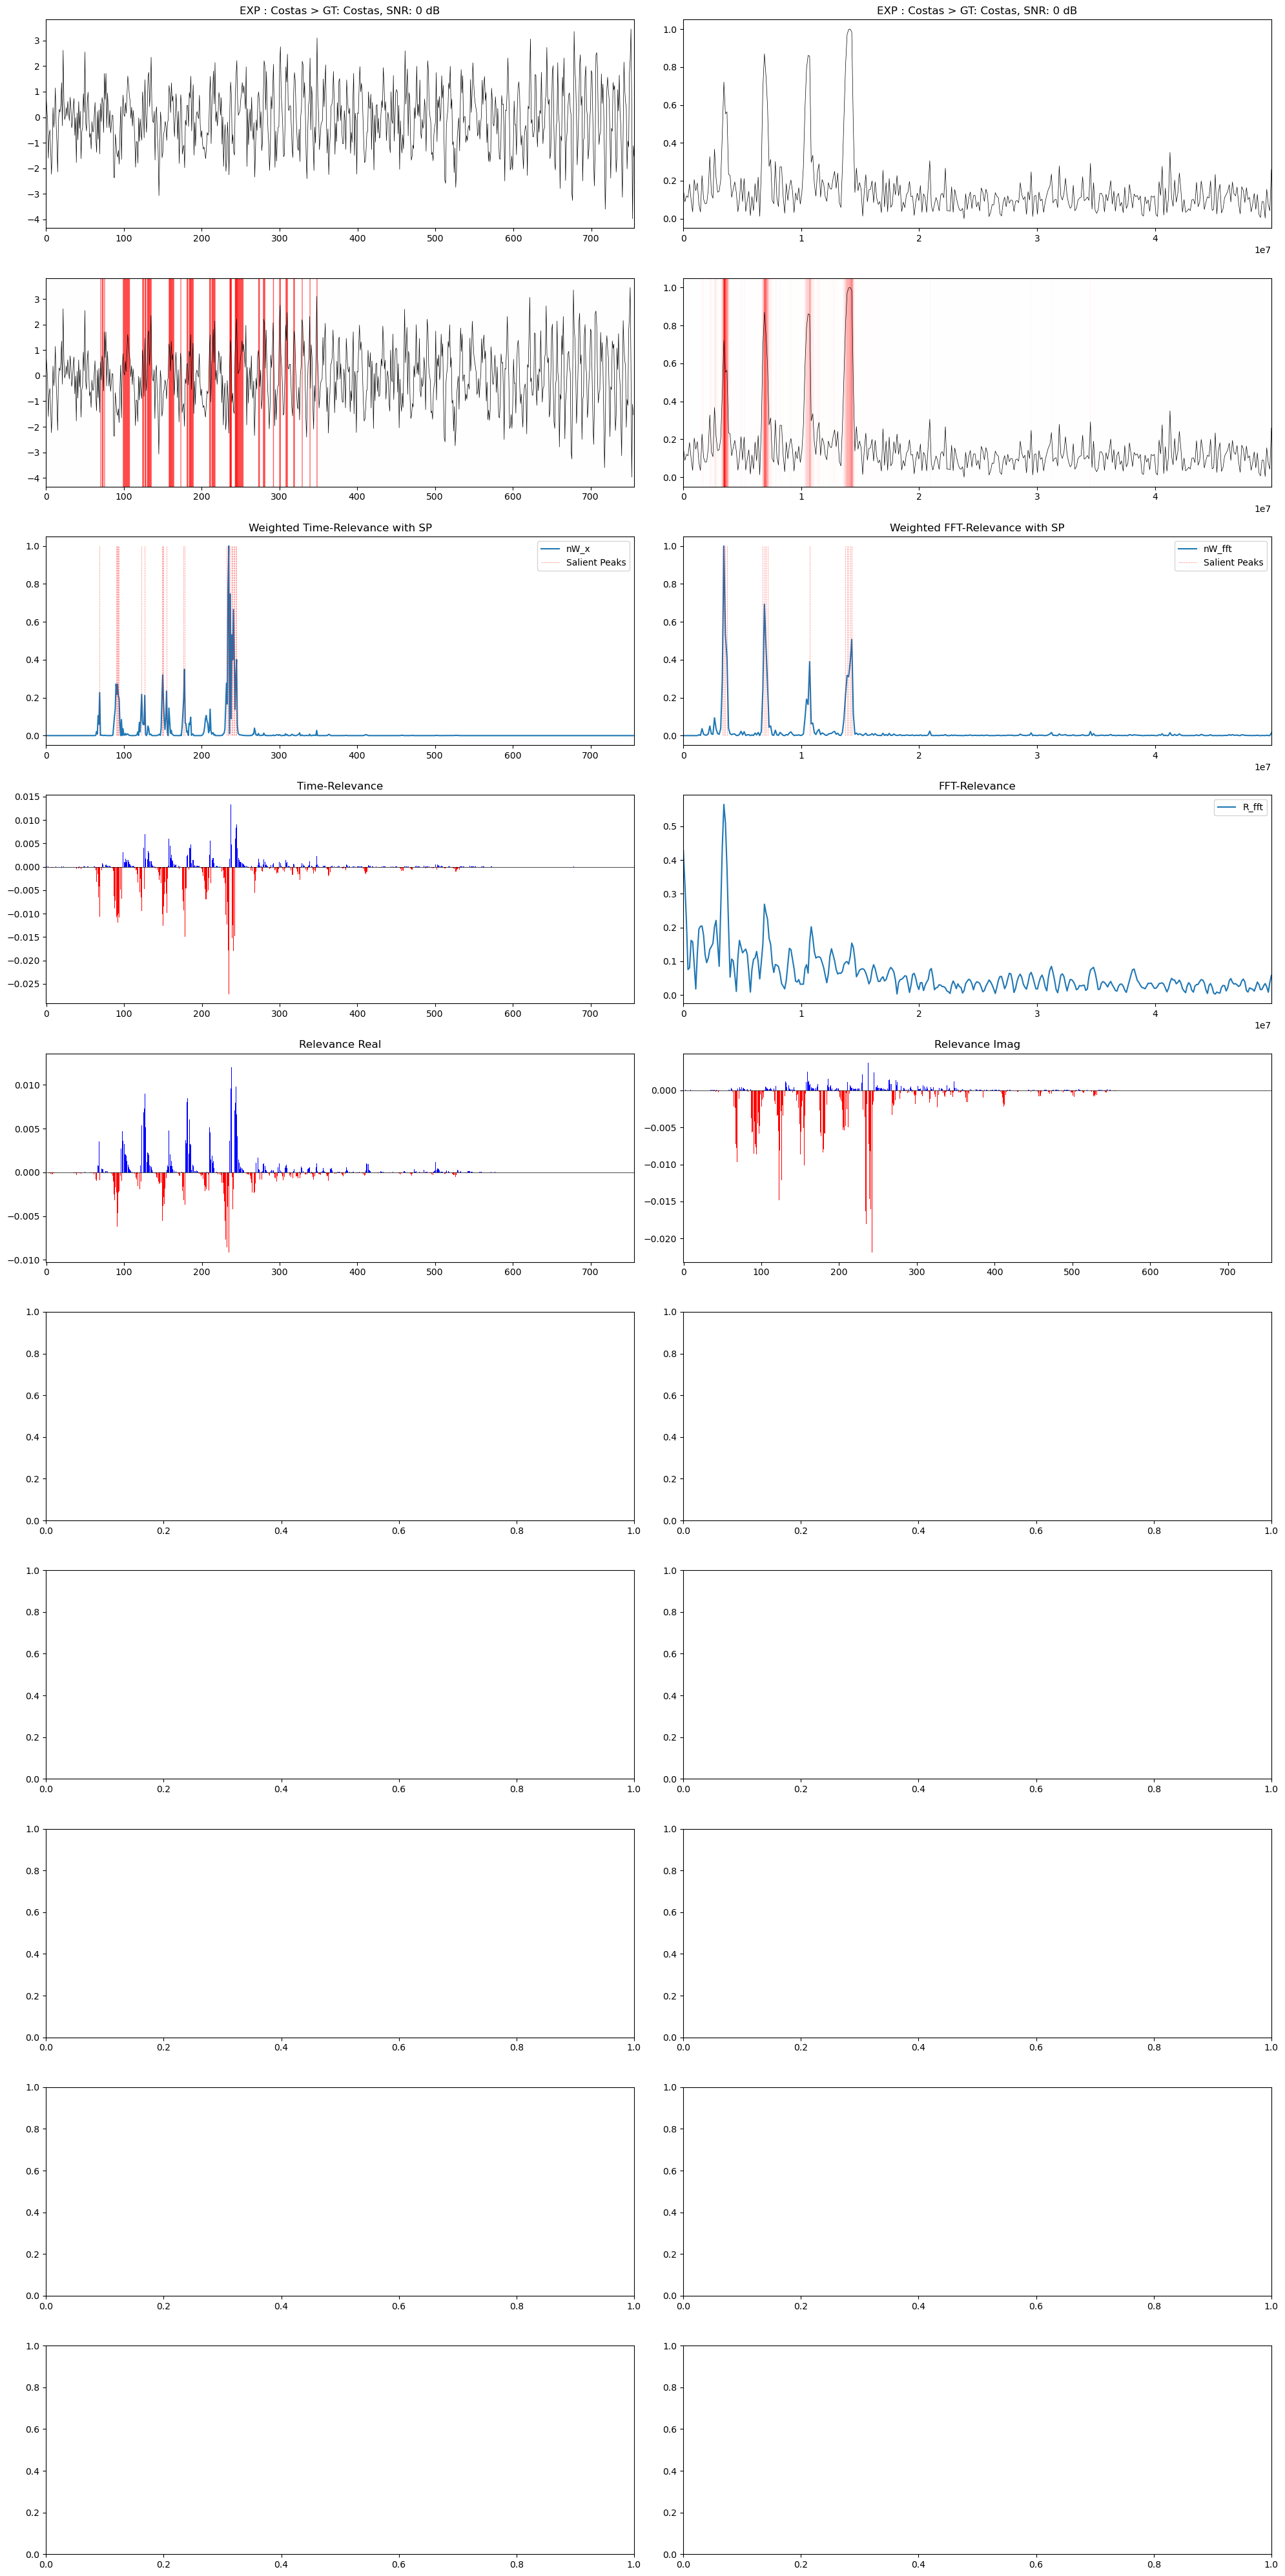

In [72]:
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from models.LSTM import BiLSTM
import numpy as np

snr_values = [0, 2, 4, 6, 8, 10, 12, 14, 16]

def snr_string(snr):
    return f'{snr}' if snr==0 else f'-{snr}'
    
def normalize(*data_arr):
    norms = []
    for data in data_arr:
        min_val = np.min(data)
        max_val = np.max(data)
        norm = (data - min_val) / (max_val - min_val)
        norms.append(norm)
    return norms

def fft_transform(data_real, data_imag):
    fs = 100e6
    complex_signal = data_real + 1j * data_imag
    fft_data = np.fft.fft(complex_signal)
    fft_amp = np.abs(fft_data)                
    fft_freq = np.fft.fftfreq(len(fft_data), 1/fs)           
    return fft_freq[:len(fft_freq)//2] ,fft_amp[:len(fft_amp) // 2] 

def stft_transform(data_real, data_imag, fs=100e6, nperseg=256):
    complex_signal = data_real + 1j * data_imag
    f, t, Zxx = stft(complex_signal, fs=fs, nperseg=nperseg)
    stft_amp = np.abs(Zxx)
    return f, t, stft_amp
    
    
def get_entropy(rel):
    rel_flat = rel.flatten()
    rel_flat = rel_flat[rel_flat > 0]
    entropys = -np.sum(rel_flat * np.log(rel_flat+1e-6))
    return entropys
    
def test_dataset(dataset, test_type, snrs, target_label, target_snr, batch_size):
    snr_data = []
    snr_batch = []
    snr_value = snr_values[:snrs]
    test_types = ['a', 'b', 'c', 'd']
    test = test_types[test_type] 
    
    # 200?
    for data, label, snr, length in dataset:
        if test == test_types[0]: # 동일 snr, 동일 label
            if snr == target_snr and label == target_label:
                snr_batch.append((data, label, snr, length))
                if len(snr_batch) == batch_size:
                    break
                    
        elif test == test_types[1]: # Label : Same, SNR : Same
            if label == target_label:
                if len([sb for _, _, sb, _ in snr_batch if sb == snr]) >= batch_size:
                    continue
                snr_batch.append((data, label, snr, length))
                
        elif test == test_types[2]: # Label : Diff, SNR : Same
            if snr == target_snr and length >= 1000 : 
                if all(existing_label != label for _, existing_label, _, _ in snr_batch):
                    snr_batch.append((data, label, snr, length))
                    if len(snr_batch) == batch_size:
                        break
        elif test == test_types[3]: # Label : Same, SNR : Diff
            if label == target_label and length >= 1000:
                if all(existing_snr != snr for _, _, existing_snr, _ in snr_batch):
                    snr_batch.append((data, label, snr, length))
                    if len(snr_batch) == batch_size:
                        break
                        
        else:
            print("Invalid test type")
    
    print(len(snr_batch))
    return snr_batch


def top_k(rel, k=10):
    return np.where(rel >= np.percentile(rel, 100-k), rel, 1e-6)

def under_k(rel, k=10):
    return np.where(rel <= np.percentile(rel, k), rel, 0)

def dynamic_k(rel, k=10): # 
    return np.mean(rel) + k * np.std(rel) 
# -------------------------------------------------------------------------------------------------------------------------------------------------
fs = 100e6
from scipy.stats import entropy
from scipy.signal import stft
def explain_set(config, train_dataset, batch_size=8, snrs=len(snr_values), test_type=1, target_snr=0, target_label='Barker'):
    device = config.device
    model = BiLSTM(input_size=2, hidden_size=128, num_layers=2, num_classes=12)

    state_dict = {}
    for k, v in torch.load('./ckpts/result_loss.pt').items():
        nk = k.replace('module.', '')
        state_dict[nk] = v
        
    model.load_state_dict(state_dict)
    model.to(device)
    model.eval()
    
    lrp = LRP(model, device=device)
    
    with torch.no_grad():
        snr_batch = test_dataset(train_dataset, test_type, snrs, target_label, target_snr, batch_size)
        
        # for i, batch in enumerate(snr_batch):
        #     for _, _, snr, _ in snr_batch:
        #         print(f"BATCH : {i} // SNR : {snr}")
            
        dataset = DataLoader(snr_batch, batch_size=batch_size, shuffle=False, collate_fn=model.collate)
        
        _, axes = plt.subplots(10,2, figsize=(20, 40))
        
        for i, batch in enumerate(dataset):
            pas_list = []
            db, lb, sb, lenb = batch
            r_cb, r_hb, rel_xb, attnb,hb, gt_label = lrp.relevance(db, lenb, target=lb)
            for j, (data, label, snr, length, r_c, r_h, rel_x, h, attn) in enumerate(zip(db, lb, sb, lenb, r_cb, r_hb, rel_xb, hb, attnb)):                
                if gt_label[j] != label:
                    continue
                
                x, R_x, Ts, W_att = data, rel_x, length, attn
                
                W_att = W_att[:Ts].cpu().numpy()
                
                x_real, x_imag = x[:Ts, :].cpu().numpy().T
                x = x_real + x_imag
                x_fft_f, x_fft_a = fft_transform(x_real, x_imag)
                
                R_x_real, R_x_imag = R_x[:Ts, :].cpu().numpy().T
                R_x = R_x_real + R_x_imag
                R_fft_f, R_fft_a = fft_transform(R_x_real, R_x_imag)
                
                R_x, R_fft_a = R_x[:len(x)], R_fft_a[:len(x_fft_a)]
                
                nR_x, nR_fft, nX_x, nX_fft = normalize(R_x, R_fft_a, x, x_fft_a)
                
                
                nR_fft[:10]=0
                R_x_top = top_k(nR_x, k=10)
                
                W_fft = (R_fft_a * x_fft_a**2)
                nW_fft = (W_fft - np.min(W_fft)) / (np.max(W_fft) - np.min(W_fft))
                nW_fft[:10] = 0
                
                W_x = (nX_x * R_x**2)
                nW_x = (W_x - np.min(W_x)) / (np.max(W_x) - np.min(W_x))
                
                sP_x = np.where(nW_x > dynamic_k(nW_x, k=2))[0]
                sP_fft = np.where(nW_fft > dynamic_k(nW_fft, k=2))[0]
                freq_SP = x_fft_f[sP_fft]
                
                # PAS
                # --------------------------------------------------------------------- 
                # print(f"Lengths : rel_salient_peaks {len(rel_salient_peaks)}")
            
                R_peaks = np.sum(nR_fft[sP_fft])
                R_total = np.sum(nR_fft)
                pas = R_peaks / R_total
                pas_list.append(pas)
                
                # ---------------------------------------------------------------------                
                
                # axes[j, 0].plot(x, color='black', label='Signal', linewidth=0.5)
                # # Hidden State
                # axes[j, 1].plot(h[:Ts, :128].cpu().numpy(), color='black', label='Hidden State', linewidth=0.5)
                # # Attention Weight
                # axes[j, 2].imshow(W_att, cmap='bwr', aspect='auto', interpolation='bilinear', extent=[0, Ts, 0, Ts], zorder=0, vmin=-1, vmax=1)
                # # Relevance_Context
                # axes[j, 3].plot(r_c[:Ts].cpu().numpy(), color='black', label='Relevance Context', linewidth=0.5)
                # # Relevance Hidden
                # axes[j, 4].plot(r_h[:Ts].cpu().numpy(), color='black', label='Relevance Hidden', linewidth=0.5)
                # # Relevance Cell state
                # axes[j, 5].plot(R_x[:Ts].cpu().numpy(), color='black', label='Relevance x', linewidth=0.5)
                
                # axes[j, 0].set_title(f'EXP : {c.signalTypes[gt_label[j]]} > GT: {c.signalTypes[label]}, SNR: {snr_string(snr)} dB')
                # axes[j, 1].set_title(f'Hidden State, SNR: {snr_string(snr)} dB')
                # axes[j, 2].set_title(f'Attention Weight, SNR: {snr_string(snr)} dB')
                # axes[j, 3].set_title(f'Relevance Context, SNR: {snr_string(snr)} dB')
                # axes[j, 4].set_title(f'Relevance Hidden, SNR: {snr_string(snr)} dB')
                # axes[j, 5].set_title(f'Relevance Cell State, SNR: {snr_string(snr)} dB')
                
                # ---------------------------------------------------------------------
                row = 0
                # axes[row, 0].plot(x_real, color='black', label='Signal', linewidth=0.5)
                # axes[row, 1].plot(x_imag, color='black', label='Signal', linewidth=0.5)
                
                axes[row, 0].plot(x, color='black', label='Signal', linewidth=0.5)
                axes[row, 1].plot(x_fft_f, nX_fft, color='black', linewidth=0.5, label='FFT Magnitude')


                axes[row, 0].autoscale(enable=True, axis='x', tight=True)
                axes[row, 1].autoscale(enable=True, axis='x', tight=True)

                axes[row, 0].set_title(f'EXP : {c.signalTypes[gt_label[j]]} > GT: {c.signalTypes[label]}, SNR: {snr_string(snr)} dB')
                axes[row, 1].set_title(f'EXP : {c.signalTypes[gt_label[j]]} > GT: {c.signalTypes[label]}, SNR: {snr_string(snr)} dB')

                # ---------------------------------------------------------------------
                row = 1 # FFT Relevance
                axes[row, 0].plot(x, color='black', label='Signal', linewidth=0.5)
                axes[row, 0].imshow(np.expand_dims(R_x_top, axis=0), cmap='bwr', aspect='auto', interpolation='bilinear',
                                 extent=[0, len(x), axes[row, 0].get_ylim()[0], axes[row, 0].get_ylim()[1]], zorder=0, alpha=1, vmin=-1, vmax=1)
                # axes[row, 0].set_title(fFFT Relevance with Top-K')

                axes[row, 1].plot(x_fft_f, nX_fft, color='black', linewidth=0.5, label='FFT Magnitude')
                axes[row, 1].imshow(np.expand_dims(nW_fft, axis=0), cmap='bwr', aspect='auto', interpolation='bilinear', 
                                 extent=[x_fft_f[0], x_fft_f[-1], axes[row, 1].get_ylim()[0], axes[row, 1].get_ylim()[1]], zorder=0, vmin=-1, vmax=1)
                # axes[row, 1].set_title(f'EXP : {c.signalTypes[gt_label[j]]} > GT: {c.signalTypes[label]}, SNR: {snr_string(snr)} dB')
                
                # ---------------------------------------------------------------------
                row = 2
                axes[row, 0].plot(nW_x, label='nW_x')
                axes[row, 0].vlines(sP_x, 0, 1, color='red', linewidth=0.5, label='Salient Peaks', alpha=0.5, linestyle='--')
                axes[row, 0].set_xlim(0, len(nW_x))
                axes[row, 0].set_title(f'Weighted Time-Relevance with SP')
                axes[row, 0].legend()
                
                axes[row, 1].plot(R_fft_f, nW_fft , label='nW_fft')
                axes[row, 1].set_xlim(0, max(R_fft_f))
                axes[row, 1].vlines(freq_SP, 0, 1, color='red', linewidth=0.5, label='Salient Peaks', alpha=0.5, linestyle='--') 
                axes[row, 1].set_title(f'Weighted FFT-Relevance with SP')
                axes[row, 1].legend()
                
                # ---------------------------------------------------------------------
                row = 3
                R_x_neg = np.where(R_x < 0)[0]
                R_x_pos = np.where(R_x >= 0)[0]
                
                # axes[row, 0].plot(R_x, label='R_x')
                axes[row, 0].hlines(0, 0, len(R_x_real), color='black', linewidth=0.5)
                axes[row, 0].bar(R_x_neg, R_x[R_x_neg], color='red', label='Negative')
                axes[row, 0].bar(R_x_pos, R_x[R_x_pos], color='blue', label='Positive')
                
                axes[row, 0].autoscale(enable=True, axis='x', tight=True) 
                axes[row, 0].set_title(f'Time-Relevance')
                
                axes[row, 1].plot(R_fft_f, R_fft_a , label='R_fft')
                axes[row, 1].set_xlim(0, max(R_fft_f))
                axes[row, 1].set_title(f'FFT-Relevance')
                axes[row, 1].legend()
                
                # ---------------------------------------------------------------------
                row = 4
                
                R_x_neg = np.where(R_x_real < 0)[0]
                R_x_pos = np.where(R_x_real > 0)[0]
                
                axes[row, 0].set_title(f'Relevance Real')
                axes[row, 0].hlines(0, 0, len(R_x_real), color='black', linewidth=0.5)
                axes[row, 0].bar(R_x_neg, R_x_real[R_x_neg], color='red', label='Negative')
                axes[row, 0].bar(R_x_pos, R_x_real[R_x_pos], color='blue', label='Positive')
                axes[row, 0].autoscale(enable=True, axis='x', tight=True)
                
                R_x_neg = np.where(R_x_imag < 0)[0]
                R_x_pos = np.where(R_x_imag >= 0)[0]
                
                axes[row, 1].set_title(f'Relevance Imag')
                axes[row, 1].hlines(0, 0, len(R_x_real), color='black', linewidth=0.5)
                axes[row, 1].bar(R_x_neg, R_x_imag[R_x_neg], color='red', label='Negative')
                axes[row, 1].bar(R_x_pos, R_x_imag[R_x_pos], color='blue', label='Positive')
                axes[row, 1].autoscale(enable=True, axis='x', tight=True)
                         
                break

            if i >= batch_size - 1: 
                break
            # print(snr, np.mean(pas_list))

    plt.tight_layout()  # 레이아웃 자동 조정
    plt.show()  # 그래프 출력
    

from models._config import C
config = C()

# for i in range(len(c.signalTypes)):
#     print(c.signalTypes[i+2])
explain_set(config, dataset, batch_size=2, snrs=8, test_type=0, target_snr=0, target_label=c.signalTypes[1])



In [7]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score

def evaluate_model_per_snr(dataloader, snr_values):
    accuracies = []
    f1_scores = []

    for snr in snr_values:
        total_preds = []
        total_labels = []

        for data_batch, labels_batch, snrs_batch, lengths_batch in dataloader:
            if snrs_batch == snr:
                data_batch = data_batch.to(device)
                labels_batch = labels_batch.to(device)

                with torch.no_grad():
                    outputs = model(data_batch, lengths_batch)
                    preds = torch.argmax(outputs, dim=1)
                    
                total_preds.append(preds.cpu().numpy())
                total_labels.append(labels_batch.cpu().numpy())
        
        total_preds = np.concatenate(total_preds)
        total_labels = np.concatenate(total_labels)

        accuracy = accuracy_score(total_labels, total_preds)
        f1 = f1_score(total_labels, total_preds, average='macro')

        accuracies.append(accuracy)
        f1_scores.append(f1)

        print(f'SNR: {snr}, Accuracy: {accuracy:.4f}, F1-score: {f1:.4f}')

    return accuracies, f1_scores


# Relevance Score 분석 함수
def analyze_relevance_per_snr(dataloader, snr_values):
    relevance_scores = []

    for snr in snr_values:
        rel_scores_snr = []

        for data_batch, labels_batch, snrs_batch, lengths_batch in dataloader:
            if snrs_batch == snr:
                data_batch = data_batch.to(device)
                lengths_batch = lengths_batch.to(device)

                with torch.no_grad():
                    r_scores, _ = lrp.relevance(data_batch, lengths_batch)

                for i in range(data_batch.size(0)):
                    seq_len = lengths_batch[i].item()
                    rel_scores_snr.append(r_scores[i, :seq_len].cpu().numpy())
        
        relevance_scores.append(rel_scores_snr)
    
    return relevance_scores


# Relevance Score 시각화 함수
def visualize_relevance_distribution(relevance_scores, snr_values):
    fig, axs = plt.subplots(len(snr_values), 1, figsize=(10, 15))
    
    for i, snr in enumerate(snr_values):
        # Flatten all relevance scores for a given SNR
        flat_relevance = np.concatenate(relevance_scores[i])
        axs[i].hist(flat_relevance, bins=50, density=True, alpha=0.7)
        axs[i].set_title(f'Relevance Distribution for SNR: {snr}')
        axs[i].set_xlabel('Relevance Score')
        axs[i].set_ylabel('Density')
    
    plt.tight_layout()
    plt.show()


# Relevance 집중도 분석 함수 (Entropy 측정)
def relevance_concentration_analysis(relevance_scores, snr_values):
    entropies = []

    for i, rel_scores in enumerate(relevance_scores):
        entropy_snr = []

        for rel_seq in rel_scores:
            p_rel = np.abs(rel_seq) / np.sum(np.abs(rel_seq))  # Relevance 값을 확률로 변환
            entropy = -np.sum(p_rel * np.log(p_rel + 1e-6))  # 엔트로피 계산
            entropy_snr.append(entropy)
        
        avg_entropy = np.mean(entropy_snr)
        entropies.append(avg_entropy)
        print(f'SNR: {snr_values[i]}, Average Entropy: {avg_entropy:.4f}')
    
    return entropies


# SNR 값 설정
snr_values = [0, 2, 4, 6, 8, 10, 12, 14]
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = BiLSTM(input_size=2, hidden_size=128, num_layers=2, num_classes=12)

state_dict = {}
for k, v in torch.load('./ckpts/result_loss.pt').items():
    nk = k.replace('module.', '')
    state_dict[nk] = v
    
model.load_state_dict(state_dict)
model.to(device)
model.eval() 

lrp = LRP(model, device=device)

batch = DataLoader(dataset, batch_size=32, shuffle=False, collate_fn=model.collate)
# SNR별 정확도 및 F1-score 평가
accuracies, f1_scores = evaluate_model_per_snr(batch, snr_values)

# Relevance Score 분석
relevance_scores = analyze_relevance_per_snr(batch, snr_values)

# Relevance Score 분포 시각화
visualize_relevance_distribution(relevance_scores, snr_values)

# Relevance 집중도 분석 (Entropy 측정)
entropies = relevance_concentration_analysis(relevance_scores, snr_values)

# SNR별 성능 및 엔트로피 변화를 시각화
plt.figure(figsize=(10, 5))
plt.plot(snr_values, accuracies, label='Accuracy', marker='o')
plt.plot(snr_values, f1_scores, label='F1-score', marker='s')
plt.plot(snr_values, entropies, label='Entropy of Relevance', marker='x')
plt.xlabel('SNR (dB)')
plt.ylabel('Score')
plt.legend()
plt.title('SNR별 정확도, F1-score 및 Relevance Entropy')
plt.grid(True)
plt.show()


RuntimeError: Boolean value of Tensor with more than one value is ambiguous

In [ ]:
import os
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from models.LSTM import BiLSTM

def complex_sep(data):
    data = data.replace('i', 'j')  # 'i'를 'j'로 변경하여 복소수 형식에 맞춤
    complex_numbers = data.split(',')  # 쉼표로 구분된 복소수 분리
    complex_list = []
    for num in complex_numbers:
        num = complex(num.strip())
        complex_list.append(num)
    return complex_list

def exaplin_set(data):
    model = BiLSTM(input_size=2, hidden_size=128, num_layers=2, num_classes=12)
    model.load_state_dict(torch.load('/home/kiwan/TSC_XAI/ckpts/ 0dB/LSTM_ 0dB_0.0073.pt'))
    model.eval()
    
    lrp = LRP(model)
    with torch.no_grad():
        x = torch.tensor(data, dtype=torch.float).unsqueeze(0)
        lengths = torch.tensor([len(data)], dtype=torch.long)
        relevance = lrp.get_relevance(x, lengths)
	
	
        
dataset = '/data/kiwan/dataset-CWD-1000/'
signals = ['Barker', 'Costas', 'Frank', 'LFM', 'P1', 'P2', 'P3', 'P4', 'T1', 'T2', 'T3', 'T4']

for signal in signals:
    real_parts = []
    plt.figure(figsize=(20, 5))
    data_dir = os.path.join(dataset, signal)
    data_file = os.listdir(data_dir)
    for ie, file in enumerate(data_file):
        with open(os.path.join(data_dir, file), 'r') as f:
            data = f.readlines()
            data = [complex_sep(d) for d in data]
            data = [item for sublist in data for item in sublist]
            
            

        for c in data:
            real_parts.append(c.real)

        plt.axvline(x=len(real_parts), color='r', linestyle='--')
            
        if ie == 5:
            break


    plt.plot(real_parts, label='Real Part')
    # plt.plot(imag_parts, label='Imaginary Part')
    plt.title(f'{signal} Signal: Real and Imaginary Parts over Time')
    plt.xlabel('Sample Index')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.show()
        

In [ ]:

def explain_set(train_dataset):
    model = BiLSTM(input_size=2, hidden_size=128, num_layers=2, num_classes=12)
    model.load_state_dict(torch.load('/home/kiwan/TSC_XAI/ckpts/ 0dB/LSTM_ 0dB_0.0073.pt'))
    model.eval()
    
    lrp = LRP(model)

    batch = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=model.collate)

    fig = plt.figure(figsize=(20, 15))

    with torch.no_grad():
        for data_batch, labels, snr, lengths in batch:
            for i in range(len(data_batch)):
                data = data_batch[i]
                seq_len = lengths[i].item()  
                print(seq_len)
                
                # LRP로 Relevance 스코어 계산
                r_scores = lrp.get_relevance(data, seq_len)

                real_part = data_batch[i][:, 0].cpu().numpy()  # 실수부
                r_scores_real = r_scores[:, 0].cpu().numpy()   # Relevance 실수부

                ax = fig.add_subplot(4, 2, i + 1)
                ax.plot(real_part, label='Real Part')
                ax.plot(r_scores_real, label='Relevance (Real Part)', linestyle='--')
                ax.set_title(f'Sample {i+1} (SNR: {snr[i]} dB)')
                ax.legend()

            break

    plt.tight_layout()
    plt.show()

explain_set(train_dataset)